In [112]:
import nibabel as nib
import numpy as np

def adjust_affine_and_save(fus_path, mra_path, output_path):
    # Load the fUS and MRA images
    fus_img = nib.load(fus_path)
    mra_img = nib.load(mra_path)

    fus_data = fus_img.get_fdata()
    
    # Get the affine matrices
    fus_affine = fus_img.affine
    mra_affine = mra_img.affine
    
    # Define the corrected transformation matrix from LAS to RAS
    # The matrix below flips x, y, and z axes
    ras_to_pli = np.array([[-1, 0, 0, 0],
                           [0, 1, 0, 0],  # Correcting the inversion here
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
    
    # Apply the RAS to PLI transformation to the fUS affine
    transformed_fus_affine = ras_to_pli @ fus_affine
    
    # flip the z-axis on fus data
    reoriented_data = np.flip(fus_data, axis=2)

    # Adjust the translation component to match the center coordinates
    transformed_fus_affine[:3, 3] = mra_affine[:3, 3]
    
    # Save the new fUS image with the adjusted affine
    new_fus_img = nib.Nifti1Image(reoriented_data, transformed_fus_affine, fus_img.header)
    nib.save(new_fus_img, output_path)

# Paths to the fUS, MRA, and output images
fus_path = '../data/0524/fusi.nii'
mra_path = '../data/0524/angio.nii.gz'
output_path = '../data/0524/fus_in_angio_space.nii.gz'

adjust_affine_and_save(fus_path, mra_path, output_path)


pixdim[1,2,3] should be positive; setting to abs of pixdim values


In [113]:
def center_image(image_path, output_path):
    # Load the image
    img = nib.load(image_path)
    
    # Get the affine matrix
    affine = img.affine
    
    # Calculate the voxel coordinates of the center
    center_voxel = np.array(img.shape[:3]) / 2
    
    # Calculate the world coordinates of the center
    center_world = affine @ np.append(center_voxel, 1)
    
    # Calculate the translation to move the center to the origin (0, 0, 0)
    translation = -center_world[:3]
    
    # Create a translation matrix
    translation_matrix = np.eye(4)
    translation_matrix[:3, 3] = translation
    
    # Apply the translation to the affine matrix
    new_affine = translation_matrix @ affine
    
    # Save the new image with the adjusted affine
    new_img = nib.Nifti1Image(img.get_fdata(), new_affine, img.header)
    nib.save(new_img, output_path)

# Paths to the input and output images
fus_path = '../data/0524/fus_in_angio_space.nii.gz'  # Input fUS image (reoriented)
mra_path = '../data/0524/angio.nii.gz'       # Input MRA image
output_fus_path = '../data/0524/fus_in_angio_space_centered.nii.gz'  # Output centered fUS image
output_mra_path = '../data/0524/angio_centered.nii.gz'  # Output centered MRA image

# Center the fUS and MRA images
center_image(fus_path, output_fus_path)
center_image(mra_path, output_mra_path)


In [29]:
import numpy as np
import nibabel as nib
from scipy.ndimage import gaussian_filter
from skimage.filters import frangi, sato
from skimage.exposure import equalize_adapthist, rescale_intensity

In [ ]:
import matplotlib.pyplot as plt

def plot_slices(image, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    slices = [image[image.shape[0] // 2, :, :], 
              image[:, image.shape[1] // 2, :], 
              image[:, :, image.shape[2] // 2]]
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap='gray')
        axes[i].axis('off')
    if title:
        fig.suptitle(title)
    plt.show()

In [114]:
fus_path = '../data/0524/fus_in_angio_space_centered.nii.gz'
mra_path = '../data/0524/angio_centered.nii.gz'

fus_image = nib.load(fus_path)
mra_image = nib.load(mra_path)

fus_data = fus_image.get_fdata()
mra_data = mra_image.get_fdata()

# Ensure the images are of type float32
fus_data = fus_data.astype(np.float32)
mra_data = mra_data.astype(np.float32)

In [117]:
import numpy as np
from scipy.ndimage import zoom

# Assuming fus_image and mra_image are your functional ultrasound and MRA images respectively

# Voxel sizes
fus_spacing = np.array(fus_image.header.get_zooms())
mra_spacing = np.array(mra_image.header.get_zooms())

# Compute the zoom factors
zoom_factors = mra_spacing / fus_spacing

# Resample the MRA image to match the fUS voxel sizes
resampled_mra = zoom(mra_data, zoom=zoom_factors, order=1)

# save the resampled MRA image
nib.save(nib.Nifti1Image(resampled_mra, mra_image.affine), '../data/0524/angio_centered_resampled.nii.gz')

# Now both images have the same voxel sizes

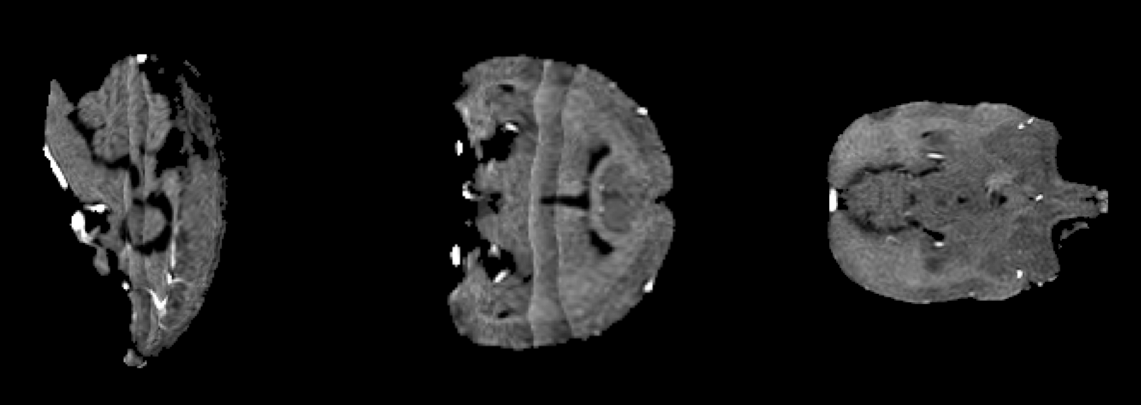

In [98]:
plot_slices(mra_data)

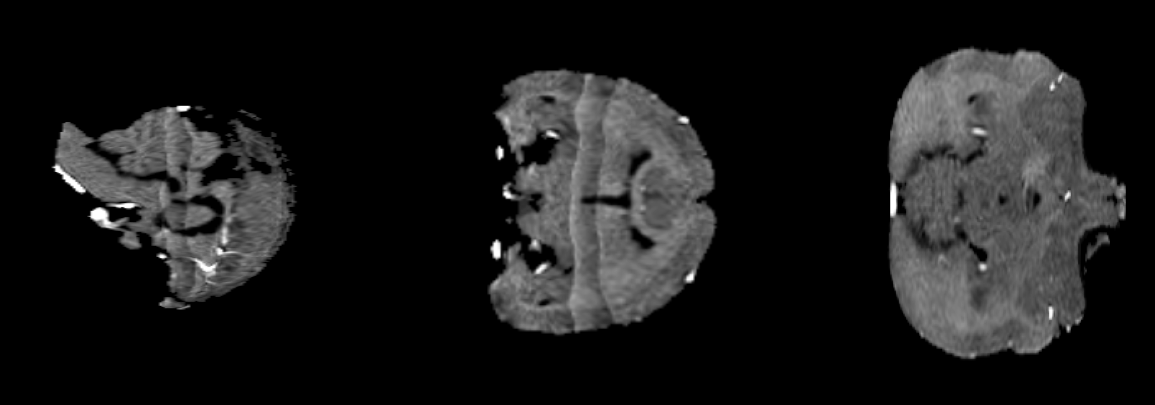

In [97]:
plot_slices(resampled_mra)

In [118]:
def pad_or_crop_image_sym(image, target_shape):
    """
    Pad or crop an image symmetrically around its center to match the target shape.
    """
    padded_image = np.zeros(target_shape, dtype=image.dtype)
    current_shape = np.array(image.shape)
    start_indices = ((target_shape - current_shape) // 2).astype(int)

    slices_src = tuple(slice(max(0, -start), min(dim, dim + min(0, start))) for start, dim in zip(start_indices, current_shape))
    slices_dst = tuple(slice(max(0, start), start + (src.stop - src.start)) for start, src in zip(start_indices, slices_src))

    padded_image[slices_dst] = image[slices_src]
    return padded_image

In [119]:
resampled_mra.shape, fus_data.shape

((267, 200, 274), (192, 151, 173))

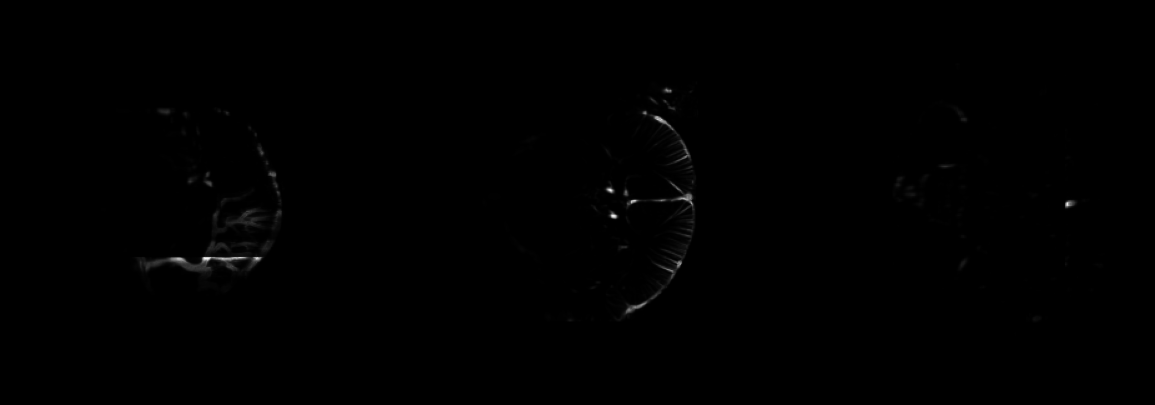

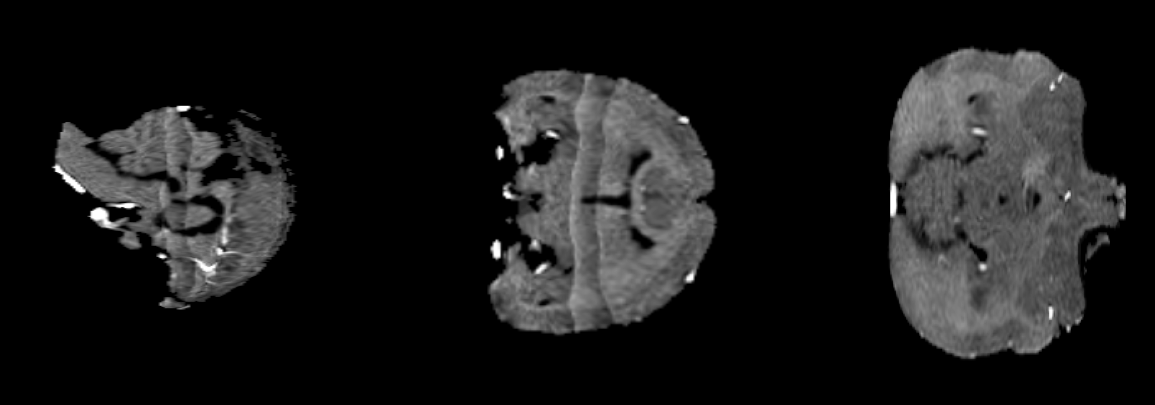

In [146]:
# Pad or crop images to the same shape
target_shape = np.maximum(resampled_mra.shape, fus_data.shape)
resampled_mra_padded = pad_or_crop_image_sym(resampled_mra, target_shape)
fus_padded = pad_or_crop_image_sym(fus_data, target_shape)

# save the padded images
nib.save(nib.Nifti1Image(fus_padded, fus_image.affine), '../data/0524/fus_in_angio_space_centered_padded.nii.gz')
nib.save(nib.Nifti1Image(resampled_mra_padded, mra_image.affine), '../data/0524/angio_centered_resampled_padded.nii.gz')

plot_slices(fus_padded)
plot_slices(resampled_mra_padded)

In [121]:
fus_padded.shape, resampled_mra_padded.shape

((267, 200, 274), (267, 200, 274))

In [122]:
# Normalize the images
mra_norm = (resampled_mra_padded - np.min(resampled_mra_padded)) / (np.max(resampled_mra_padded) - np.min(resampled_mra_padded))
fus_norm = (fus_padded - np.min(fus_padded)) / (np.max(fus_padded) - np.min(fus_padded))

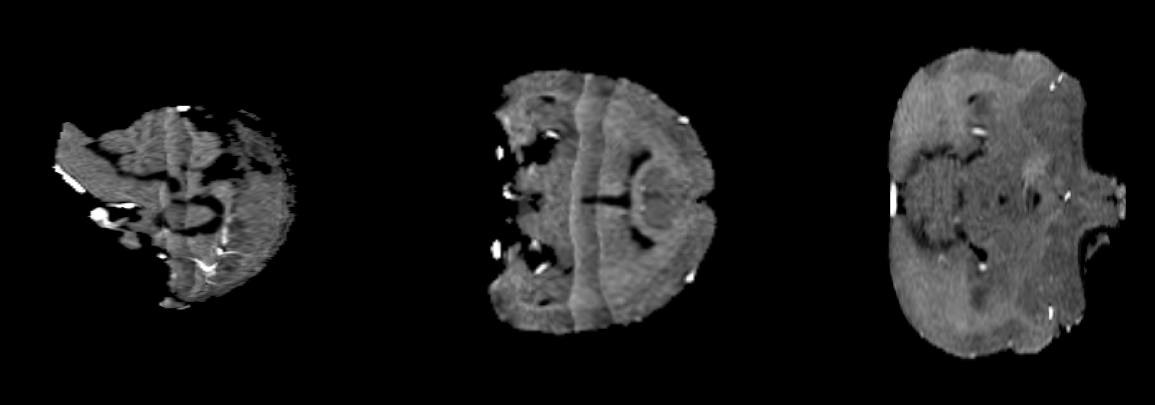

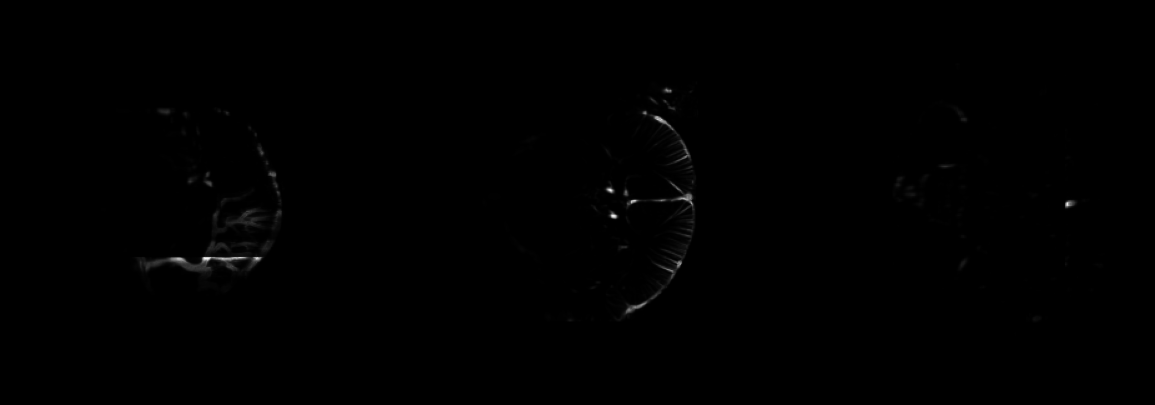

(None, None)

In [123]:
plot_slices(mra_norm), plot_slices(fus_norm)

In [140]:
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import TranslationTransform3D

# Adjusted metric parameters
metric = MutualInformationMetric(nbins=50, sampling_proportion=0.2)  # Increased nbins, reduced sampling proportion

# Adjusted level iterations
level_iters = [2000, 1000, 500]  # Reduced for faster initial testing

# Adjusted sigmas
sigmas = [3.0, 1.0, 0.5]  # Added an intermediate level for finer control

# Adjusted factors
factors = [4, 2, 1]

affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
transform = TranslationTransform3D()
params0 = None

affine_map = affreg.optimize(static=mra_norm, moving=fus_norm, transform=transform, params0=params0)
registered_image = affine_map.transform(fus_norm)

Optimizing level 2 [max iter: 2000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 500]


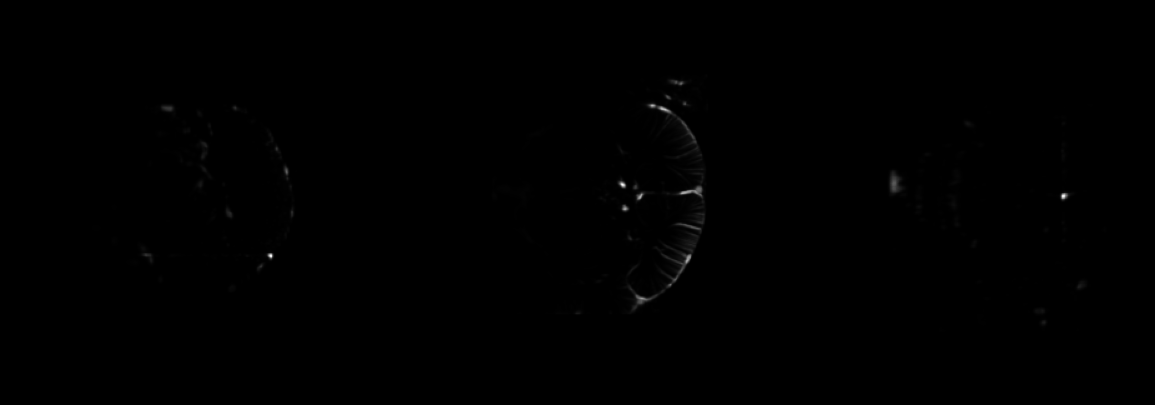

In [141]:
plot_slices(registered_image)

In [144]:
output_path = '../data/0524/fus_in_angio_space_centered_padded_registered.nii.gz'
nib.save(nib.Nifti1Image(registered_image, affine_map.affine), output_path)

In [143]:
import matplotlib.pyplot as plt

def plot_overlay(image1, image2, slice_idx):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(image1[:, slice_idx, :], cmap='gray')
    ax[0].set_title('Reference Image')
    
    ax[1].imshow(image2[:, slice_idx, :], cmap='gray')
    ax[1].set_title('Registered Image')
    
    ax[2].imshow(image1[:, slice_idx, :], cmap='gray', alpha=0.5)
    ax[2].imshow(image2[:, slice_idx, :], cmap='hot', alpha=0.5)
    ax[2].set_title('Overlay')
    
    plt.show()

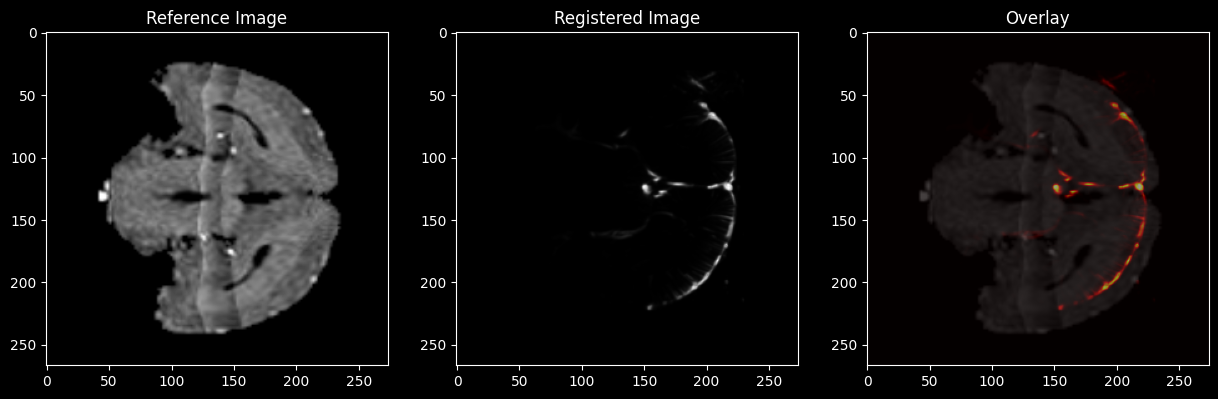

In [142]:
plot_overlay(resampled_mra_padded, registered_image, slice_idx=80)

In [145]:
image_path = '../data/0524/fus_in_angio_space_centered_padded_registered.nii.gz'
output_path = '../data/0524/fus_in_angio_space_centered_padded_registered_centered.nii.gz'
center_image(image_path, output_path)

In [149]:
mra_path = '../data/0524/angio_centered_resampled_padded.nii.gz'
fus_path = '../data/0524/fus_in_angio_space_centered_padded.nii.gz'

In [148]:
import ants

fixed = ants.image_read(mra_path)
moving = ants.image_read(fus_path)

# Perform rigid registration as a pre-step
rigid = ants.registration(fixed=fixed, moving=moving, type_of_transform='Rigid')

# Use the result of the rigid registration to initialize the next step
rigid_transformed = rigid['warpedmovout']

# Perform further registration with affine transformation
affine = ants.registration(fixed=fixed, moving=rigid_transformed, type_of_transform='Affine')

# Use the result of the affine registration to initialize the non-linear step
affine_transformed = affine['warpedmovout']

# Perform non-linear registration
# Using 'CC' (Cross-Correlation) as the similarity metric
syn = ants.registration(fixed=fixed, moving=affine_transformed, type_of_transform='SyN',
                        reg_iterations=(100, 70, 50),
                        aff_metric='mattes',
                        syn_metric='CC',
                        syn_sampling=4)

# Get the final registered image
registered_image = syn['warpedmovout']
ants.image_write(registered_image, '../data/0524/registered_fus_image_ants.nii.gz')


In [153]:
import pyelastix as pelx

# Load images
fixed_image = nib.load(mra_path)
moving_image = nib.load(fus_path)

# Get image data and affine
fixed_data = np.ascontiguousarray(fixed_image.get_fdata(), dtype=np.float32)
moving_data = np.ascontiguousarray(moving_image.get_fdata(), dtype=np.float32)
fixed_affine = fixed_image.affine
moving_affine = moving_image.affine

# Define parameters for registration
params = pelx.get_default_params()
params.NumberOfResolutions = 3
params.FinalGridSpacingInPhysicalUnits = 8
params.MaximumNumberOfIterations = 500
params.NumberOfSpatialSamples = 2048

# Perform registration
result = pelx.register(fixed_data, moving_data, params)

# Get registered image and transformation matrix
registered_data = result[0]
transform = result[1]

# Save the registered image
registered_image = nib.Nifti1Image(registered_data, fixed_affine)
nib.save(result_image, '../data/0524/registered_fus_image_elastix.nii')


RuntimeError: Could not find Elastix executable. Download Elastix from http://elastix.isi.uu.nl/. Pyelastix looks for the exe in a series of common locations. Set ELASTIX_PATH if necessary.

In [154]:
import subprocess

# Perform registration using FLIRT (command-line tool)
subprocess.run(['flirt', '-in', '../data/0524/fus_in_angio_space_centered_padded.nii.gz', '-ref', '../data/0524/angio_centered_resampled_padded.nii.gz', '-out', '../data/0524/registered_fus_image_flirt.nii', '-omat', 'fus_to_mra.mat'])

# Check the output files 'registered_fus_image_flirt.nii' and 'fus_to_mra.mat' for the registered image and transformation matrix, respectively.


CompletedProcess(args=['flirt', '-in', '../data/0524/fus_in_angio_space_centered_padded.nii.gz', '-ref', '../data/0524/angio_centered_resampled_padded.nii.gz', '-out', '../data/0524/registered_fus_image_flirt.nii', '-omat', 'fus_to_mra.mat'], returncode=0)